In [4]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
import json

# Modelos de Machine Learning e Deep Learning
# 📊SVR
#### 💾 Carregamento e preparação da série temporal

In [5]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Função para montar o design-matrix a partir de DateTime + colunas originais
def create_features(df):
    X = pd.DataFrame({
        "Hour": df["Hour"],
        "Temperature": df["Temperature"]
    })

    # mapeia TimeOfDay para ordinal
    tod_map = {"Manhã":0, "Tarde":1, "Noite":2}
    X["TimeOfDay"] = df["TimeOfDay"].map(tod_map).fillna(0).astype(int)

    # mapeia DayOfTheWeek para ordinal
    dofw_map = {"Segunda":0, "Terça":1, "Quarta":2, "Quinta":3, "Sexta":4, "Sábado":5, "Domingo":6}
    X["DayOfTheWeek"] = df["DayOfTheWeek"].map(dofw_map).fillna(0).astype(int)

    return X

#### ✂️ Split treino/teste

In [6]:
train_df = df_cp[df_cp["DateTime"] < "2023-09-30"]
test_df  = df_cp[
    (df_cp["DateTime"] >= "2023-09-30") &
    (df_cp["DateTime"] <  "2023-10-01")
]

X_train = create_features(train_df)
y_train = train_df["EnergyNormalized"].to_numpy()
X_test  = create_features(test_df)
y_test  = test_df["EnergyNormalized"].to_numpy()

In [7]:
# Escala features
# 1) Escolha as colunas a escalar
cols_to_scale = ["Hour", "Temperature"]

# 2) Crie o scaler e ajuste só no treino
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

# 3) Aplique a transformação somente nessas colunas
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

#### 💾 Carregamento do modelo

In [8]:
# (Opcional) Carrega um modelo previamente treinado.
pipeline = load("predicts/SVR/modelo/SVR_pipeline.joblib")

#### 🛠️ Treinar

In [5]:
pipeline = Pipeline([
    ("scaler", ColumnTransformer([
        ("hour_temp", StandardScaler(), ["Hour", "Temperature"])
    ], remainder="passthrough")),  # as outras colunas passam sem alteração
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.01))
])
pipeline.fit(X_train, y_train)

dump(pipeline, "predicts/SVR/modelo/SVR_pipeline.joblib") # Guarda o modelo treinado.

['predicts/SVR/modelo/SVR_pipeline.joblib']

#### 📈 Previsão e avaliação

In [10]:
y_pred = pipeline.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test)*100).mean()

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape
}

with open("./predicts/SVR/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f}%")

MAE:  0.00543
MSE:  0.00004
RMSE: 0.00601
MAPE: 11.54%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                                                  |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00543 | O erro médio absoluto é bastante baixo, o que indica que as previsões do SVR, em média, diferem pouco dos valores reais. Um bom resultado para previsão horária.                               |
| **MSE** (Erro Quadrático Médio)              | 0.00004 | Um MSE extremamente baixo mostra que grandes desvios são raros, o que indica boa estabilidade do modelo mesmo nas zonas com variações mais acentuadas.                                         |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00601 | Representa o erro médio esperado com a mesma unidade da variável alvo. Um RMSE em torno de 0.006 indica que o SVR está a prever com boa precisão geral.                                        |
| **MAPE** (Erro Percentual Absoluto Médio)    | 11.54%  | Um erro percentual de 11.5% é bastante aceitável em séries temporais de consumo energético, embora inferior ao XARIMA (5.55%), é significativamente melhor que ARIMA puro ou Regressão Linear. |

#### 🖼️ Visualização gráfica

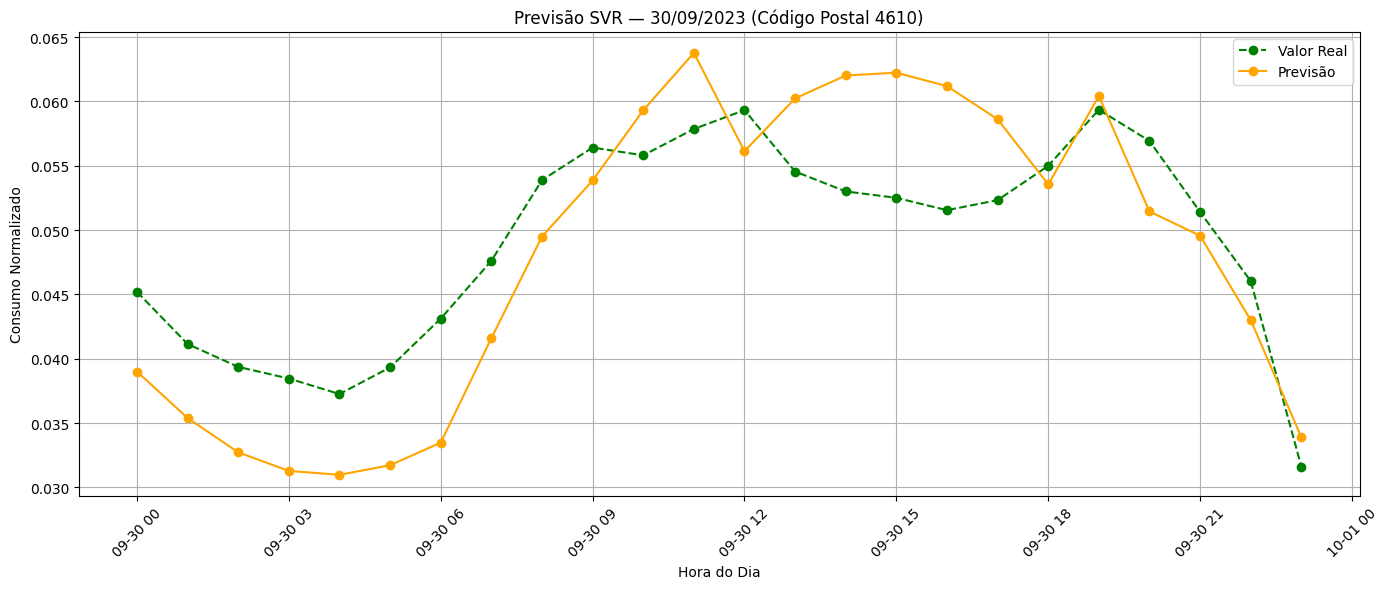

In [7]:
timestamps = test_df["DateTime"]

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_test, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão SVR — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/SVR/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊RF
#### 💾 Carregamento e preparação da série temporal

In [11]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Função para montar o design-matrix a partir de DateTime + colunas originais
def create_features(df):
    X = pd.DataFrame({
        "Hour": df["Hour"],
        "Temperature": df["Temperature"]
    })

    # mapeia TimeOfDay para ordinal
    tod_map = {"Manhã":0, "Tarde":1, "Noite":2}
    X["TimeOfDay"] = df["TimeOfDay"].map(tod_map).fillna(0).astype(int)

    # mapeia DayOfTheWeek para ordinal
    dofw_map = {"Segunda":0, "Terça":1, "Quarta":2, "Quinta":3, "Sexta":4, "Sábado":5, "Domingo":6}
    X["DayOfTheWeek"] = df["DayOfTheWeek"].map(dofw_map).fillna(0).astype(int)

    return X

#### ✂️ Split treino/teste

In [12]:
train_df = df_cp[df_cp["DateTime"] < "2023-09-30"]
test_df  = df_cp[
    (df_cp["DateTime"] >= "2023-09-30") &
    (df_cp["DateTime"] <  "2023-10-01")
]

X_train = create_features(train_df)
y_train = train_df["EnergyNormalized"].to_numpy()
X_test  = create_features(test_df)
y_test  = test_df["EnergyNormalized"].to_numpy()

In [13]:
# Escala features
# 1) Escolha as colunas a escalar
cols_to_scale = ["Hour", "Temperature"]

# 2) Crie o scaler e ajuste só no treino
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

# 3) Aplique a transformação somente nessas colunas
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

#### 💾 Carregamento do modelo

In [14]:
# (Opcional) Carrega um modelo previamente treinado.
pipeline = load("predicts/RF/modelo/RF_pipeline.joblib")

#### 🛠️ Treinar

In [12]:
pipeline = Pipeline([
    ("scaler", ColumnTransformer([
        ("hour_temp", StandardScaler(), ["Hour", "Temperature"])
    ], remainder="passthrough")),  # as outras colunas passam sem alteração
    ("rf", RandomForestRegressor(n_estimators=100, random_state=123, n_jobs=-1))
])
pipeline.fit(X_train, y_train)

dump(pipeline, "predicts/RF/modelo/RF_pipeline.joblib") # Guarda o modelo treinado.

['predicts/RF/modelo/RF_pipeline.joblib']

#### 📈 Previsão e avaliação

In [15]:
y_pred = pipeline.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test)*100).mean()

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape
}

with open("./predicts/RF/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f}%")

MAE:  0.00337
MSE:  0.00002
RMSE: 0.00438
MAPE: 7.55%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação |
|----------------------------------------------|---------|---------------|
| **MAE** (Erro Absoluto Médio)                | 0.00337 | O erro médio absoluto é bastante reduzido, indicando que, em média, a RF prevê o consumo com um desvio muito pequeno em relação aos valores reais. |
| **MSE** (Erro Quadrático Médio)              | 0.00002 | Um erro quadrático médio extremamente baixo, sugerindo que grandes erros são raros. O modelo apresenta alta precisão e estabilidade nas previsões. |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00438 | Com um RMSE inferior a 0.005, o modelo consegue manter os erros dentro de uma margem pequena em relação à variabilidade do consumo energético. |
| **MAPE** (Erro Percentual Absoluto Médio)    | 7.55%   | O erro percentual médio de cerca de 7,5\% mostra que a RF prevê com boa precisão, ficando muito próxima do desempenho do modelo XARIMA. |

#### 🖼️ Visualização gráfica

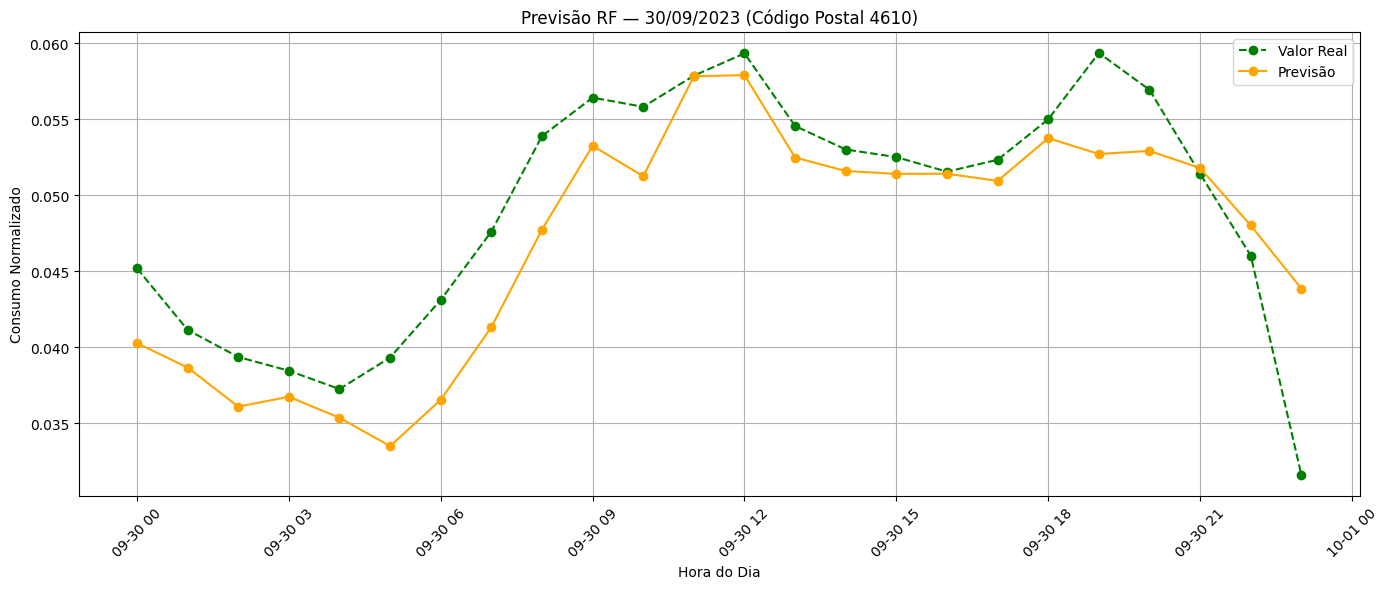

In [14]:
timestamps = test_df["DateTime"]

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_test, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão RF — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/RF/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊LSTM
#### 💾 Carregamento e preparação da série temporal

In [16]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [17]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo LSTM


In [18]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_lstm = TimeSeriesPredictor.load("./predicts/LSTM/modelo/")

In [23]:
# --- 3) Treinar um LSTM (via RNNModel) ---
predictor_lstm = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/LSTM/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "DeepAR": {
            "context_length": 48,    # quantas horas passadas a rede olha
            "hidden_size":   64,    # tamanho do estado escondido
            "num_layers":    2,     # número de camadas LSTM
            "dropout":       0.1,
            "learning_rate": 1e-3,
            "epochs":        20,
            "target_scaler": "standard",
        }
    },
    presets="medium_quality",
    time_limit=3600,               # 1h de tempo máximo
)

predictor_lstm.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\LSTM\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       0.74 GB / 7.88 GB (9.4%)
Disk Space Avail:   886.20 GB / 931.51 GB (95.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'context_length': 48,
                                'dropout': 0.1,
                                'epochs': 20,
                                'hidden_size': 64,
                                'learning_rate': 0.001,
                                'num_layers': 2,
                                'target_scaler': 'standard'}},
 'known_covariates_names

#### 🔮Preparação das covariáveis futuras para previsão

In [19]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [20]:
preds = predictor_lstm.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_lstm.evaluate(test_data)

#### 📊 Cálculo de métricas

In [21]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape
}

with open("./predicts/LSTM/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')

MAE: 0.00239
MSE: 0.00001
RMSE: 0.00336
MAPE: 5.21063%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                       |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00239 | O LSTM apresenta um erro médio extremamente baixo, o que indica uma capacidade muito elevada de seguir o consumo real hora a hora.                  |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O valor reduzido mostra que o modelo raramente comete grandes erros e tem previsões muito estáveis, sem picos de desvio elevados.                   |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00336 | Representa um erro médio em torno de 0.00336, muito inferior ao observado na maioria dos modelos testados, sinalizando alta precisão global.        |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.21%   | O LSTM atinge o melhor resultado percentual até agora, errando em média menos de 5% em relação aos valores reais — excelente para aplicações reais. |

#### 🖼️ Visualização gráfica

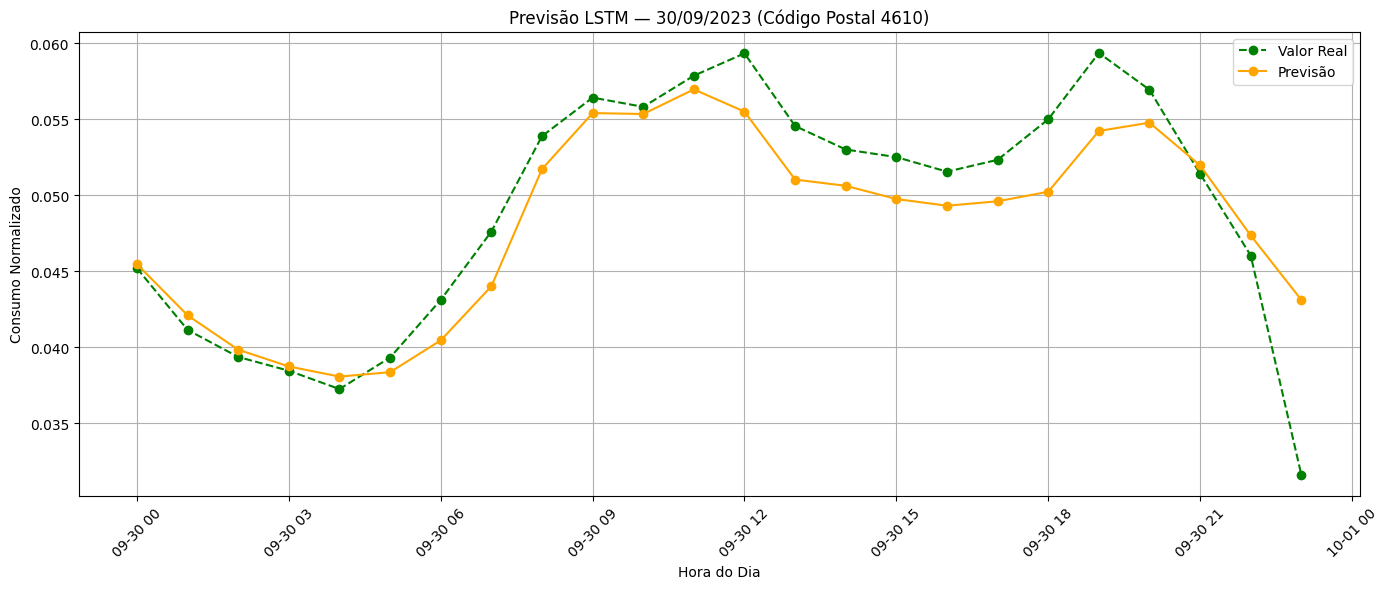

In [27]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão LSTM — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/LSTM/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊CNN
#### 💾 Carregamento e preparação da série temporal

In [22]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [23]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo CNN

In [24]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_cnn = TimeSeriesPredictor.load("./predicts/CNN/modelo/")

In [35]:
# --- 3) Treinar um CNN ---
predictor_cnn = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/CNN/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "WaveNet": {}
    },
    presets="medium_quality",
    time_limit=600,
    skip_model_selection=True
)

predictor_cnn.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\CNN\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.11 GB / 7.88 GB (14.1%)
Disk Space Avail:   886.19 GB / 931.51 GB (95.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'WaveNet': {}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'EnergyNormalized',
 'time_limit': 600,
 've

#### 🔮Preparação das covariáveis futuras para previsão

In [25]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [26]:
preds = predictor_cnn.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_cnn.evaluate(test_data)

#### 📊 Cálculo de métricas

In [27]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape
}

with open("./predicts/CNN/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')

MAE: 0.00373
MSE: 0.00003
RMSE: 0.00516
MAPE: 8.07783%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação |
|----------------------------------------------|---------|---------------|
| **MAE** (Erro Absoluto Médio)                | 0.00373 | O erro médio absoluto é baixo, indicando que as previsões da CNN estão geralmente muito próximas dos valores reais de consumo energético. |
| **MSE** (Erro Quadrático Médio)              | 0.00003 | O erro quadrático médio também é reduzido, o que mostra que grandes desvios entre previsão e realidade são pouco frequentes. |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00516 | Com um RMSE inferior a 0.01, o modelo mantém os erros dentro de uma margem aceitável, demonstrando uma boa estabilidade nas previsões horárias. |
| **MAPE** (Erro Percentual Absoluto Médio)    | 8.08%   | O modelo apresenta um erro percentual médio de aproximadamente 8%, o que é considerado bom para séries temporais energéticas, mas ligeiramente inferior ao LSTM. |

#### 🖼️ Visualização gráfica

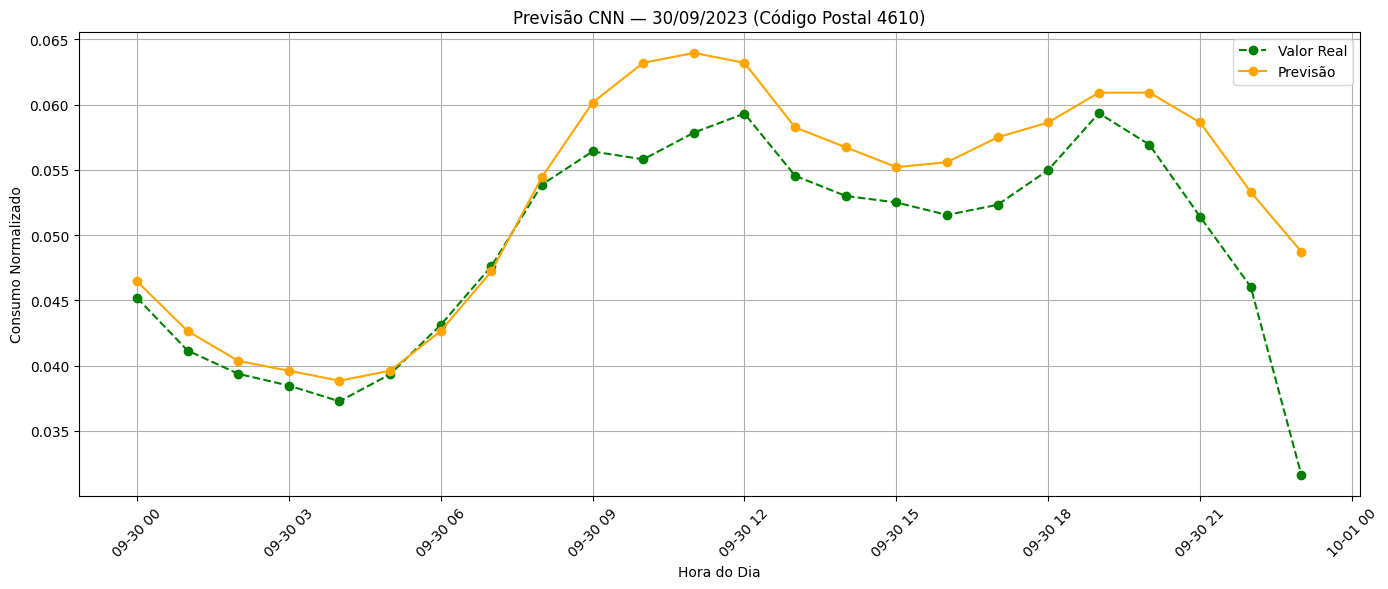

In [41]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão CNN — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/CNN/grafico.png", dpi=300, bbox_inches='tight')
plt.show()